# Load Data

In [1]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

# TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [74]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 100

In [75]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [125]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 5
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 32
    # gradient_accumulation_steps = 1

    lr = 1e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 50
    frozen_layers = 0
    
    cl_method = 'SupCon'

In [ ]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

In [77]:
device = torch.device(CFG.device)

# Load train data

In [78]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv')).sample(frac=1).reset_index(drop=True)
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,13810,13819,17340_right,0
1,22083,22097,27852_right,0
2,27552,27568,34901_left,4
3,15987,15997,20070_right,0
4,16171,16181,20273_right,0
...,...,...,...,...
35103,16850,16861,21138_right,0
35104,6265,6269,7883_right,3
35105,11284,11291,14181_right,0
35106,860,861,1042_right,0


In [79]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)]
len(train_data)

19944

In [80]:
train_data.level.value_counts()

level
0    14637
2     2982
1     1405
3      498
4      422
Name: count, dtype: int64

In [81]:
# take only 100 samples from each class
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
train_data.level.value_counts()

level
0    50
4    50
3    50
2    50
1    50
Name: count, dtype: int64

# Dataset

In [82]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [105]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.7),
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    CustomTransform(),
    # v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    # v2.RandomGrayscale(p=0.2),
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    v2.RandomGrayscale(p=0.2),
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [106]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

In [107]:
class ContrastiveLearningDataset(Dataset):
    def __init__(self, folder, data, transform=None):
        self.folder = folder
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.folder}{self.data.loc[idx, 'image']}.jpeg"
        label = self.data.loc[idx, 'level']
        image = Image.open(img_name).convert('RGB')

        if self.transform is not None:
            xi = self.transform(image)
            xj = self.transform(image)  # Apply the same transform twice
        else:
            xi = xj = image

        return [xi, xj], torch.tensor(label, dtype=torch.long)

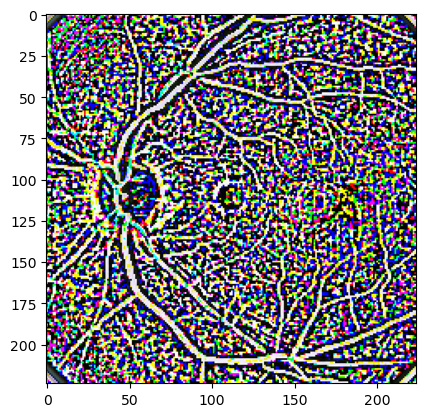

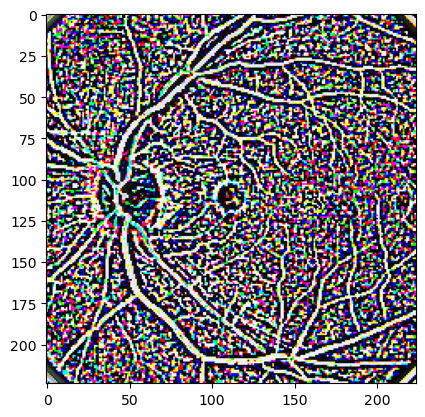

tensor(0)

In [112]:
# visualize the transformations
train_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, train_data, train_transforms)
imgs, label = train_dataset[9]
transformed_img_pil = func.to_pil_image(imgs[0])
plt.imshow(transformed_img_pil)
plt.show()

transformed_img_pil_2 = func.to_pil_image(imgs[1])
plt.imshow(transformed_img_pil_2)
plt.show()
label

# Metric

In [113]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score

In [114]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

# Train and evaluate functions

In [115]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [116]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [132]:
def train_epoch(cfg, train_loader, model, criterion, device, optimizer, scheduler, epoch):  
    model.train()

    train_loss = 0
    learning_rate_history = []
    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)

    for step, (images, labels) in tk0:
        print(images.shape)
        images = torch.cat([images[0], images[1]], dim=0)
        
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        bsz = labels.shape[0]
        
        # compute loss
        features = model(images)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        
        if CFG.cl_method == 'SupCon':
            loss = criterion(features, labels)
        elif CFG.cl_method == 'SimCLR':
            loss = criterion(features)
        else:
            raise ValueError(f"Unknown contrastive learning method: {CFG.cl_method}")
        
        loss.backward()
        
        train_loss += loss.item()

        # Update learning rate scheduler if present
        if scheduler is not None:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]
        else:
            lr = optimizer.param_groups[0]['lr']
        
        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

    train_loss /= total_len

    print(f'Epoch {epoch}: training loss = {train_loss:.4f}')
    return train_loss, learning_rate_history

# Train model

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

In [133]:
def freeze_initial_layers(model, freeze_up_to_layer=3):
    # The ResNet50 features block is typically named 'layerX' in PyTorch
    layer_names = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4']
    # Iterate over model children (first level only, adjust as needed)
    for name, child in model.named_children():
        if name in layer_names[:freeze_up_to_layer]:
            for param in child.parameters():
                param.requires_grad = False
            print(f'Layer {name} has been frozen.')
        else:
            print(f'Layer {name} is trainable.')

In [134]:
def create_model():
    model = timm.create_model(CFG.model_name, features_only=True, pretrained=True)
    freeze_initial_layers(model, freeze_up_to_layer=CFG.frozen_layers)
    return model.to(device)

In [135]:
class SupConModel(nn.Module):
    def __init__(self, encoder, input_dim=2048, output_dim=128):        # assuming either resnet50 or resnet101 is used
        super().__init__()
        self.encoder = encoder
        self.head = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        ft = self.encoder(x)
        return F.normalize(self.head(ft), dim=1)

In [136]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def get_embeddings(model, data_loader):
    model.eval()

    features = []
    targets = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            embds = model(images)

            features.append(embds.detach().cpu())
            targets.append(target.detach().cpu())

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # store the embeddings for future use
    torch.save(features, os.path.join(wandb.run.dir, f"embeddings.pth"))
    torch.save(targets, os.path.join(wandb.run.dir, f"targets.pth"))

    return features, targets


def plot_tsne(embeddings, labels, name='tsne.png'):
    # Apply t-SNE to the embeddings
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings.numpy())

    # Define the number of unique labels/classes
    num_classes = len(np.unique(labels.numpy()))
    # Create a custom color map with specific color transitions
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=num_classes)

    # Create a boundary norm with boundaries and colors
    norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 0.5, 1), cmap.N)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
    colorbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
    colorbar.set_label('Severity Level')
    colorbar.set_ticklabels(np.arange(num_classes))  # Set discrete labels if needed
    plt.title('t-SNE of Image Embeddings with Discrete Severity Levels')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.savefig(os.path.join(wandb.run.dir, name), dpi=300, bbox_inches='tight')


## Train folds

In [137]:
seed_everything(CFG.seed)

# # Prepare datasets and data loaders
# fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
# fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

train_dataset = ContrastiveLearningDataset(TRAIN_DATA_FOLDER, train_data, transform=train_transforms)
# valid_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    pin_memory=True,
    drop_last=True
)

# Prepare model, optimizer, and scheduler
resnet = create_model()
model = SupConModel(resnet).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader))

criterion = SupConLoss()

for epoch in range(CFG.epochs):
    train_loss, train_lr = train_epoch(CFG, train_loader, model, criterion, device, optimizer, scheduler, epoch)
    scheduler.step()  # Update the learning rate scheduler at the end of each epoch

    if epoch % 1 == 0:
        torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'ckpt_epoch_{epoch}.pth'))

        # plot a tsne plot of all the images using embeddings from the model
        full_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transforms=val_transforms)
        loader = DataLoader(
            full_dataset,
            batch_size=CFG.batch_size,
            shuffle=False,
            num_workers=CFG.workers,
            pin_memory=True,
            drop_last=False,
        )

        features, targets = get_embeddings(model, loader)
        plot_tsne(features, targets, f'tsne_{epoch}.png')

Layer conv1 is trainable.
Layer bn1 is trainable.
Layer act1 is trainable.
Layer maxpool is trainable.
Layer layer1 is trainable.
Layer layer2 is trainable.
Layer layer3 is trainable.
Layer layer4 is trainable.


  0%|                                                                              | 0/7 [00:00<?, ?it/s]

In [ ]:
wandb.finish()